# Scenario X Config -> score training with Random Forest Regression

In [15]:
import pandas as pd
import numpy as np
import seaborn as sns
from tqdm import tqdm
import pickle
import json
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
RSEED = 50

## Load tables and clean data

In [2]:
# Load in data
config_df = pd.read_parquet("timely_mean_mota_df.pq")
config_df

,D-model,run,D-conf,D-seq-pol,T-model,T-min-iou,T-max-age,T-every-nth-det,metric,eval_mode,path,mean_score
index,,,,,,,,,,,,
65,efficientdet-d1,training_0000-S5,0.3,eager,sort,0.5,7,5,T_mota,timely,../../ad-config-search/12-02-results/34.222.10...,-4.078038
113,efficientdet-d1,training_0000-S2,0.3,eager,sort,0.2,1,3,T_mota,timely,../../ad-config-search/12-02-results/35.162.21...,20.879074
209,efficientdet-d3,training_0000-S9,0.5,tail-aware,sort,0.3,1,5,T_mota,timely,../../ad-config-search/12-02-results/34.220.13...,23.972345
257,efficientdet-d1,training_0000-S20,0.3,tail-aware,sort,0.2,7,3,T_mota,timely,../../ad-config-search/12-02-results/34.220.13...,35.430093
353,efficientdet-d5,training_0000-S10,0.5,eager,sort,0.5,3,1,T_mota,timely,../../ad-config-search/12-02-results/34.219.11...,43.338232
...,...,...,...,...,...,...,...,...,...,...,...,...
21823217,efficientdet-d2,training_0003-S0,0.3,wait,sort,0.2,5,3,T_mota,timely,../../ad-config-search/12-06-v7/1607283808952,14.305678
21823265,efficientdet-d6,training_0003-S20,0.3,wait,sort,0.2,5,1,T_mota,timely,../../ad-config-search/12-06-v7/1607292078728,30.733926
21823313,efficientdet-d4,training_0002-S8,0.3,tail-aware,sort,0.5,5,5,T_mota,timely,../../ad-config-search/12-06-v7/1607275191682,-27.582805


In [3]:
config_df = config_df[config_df["metric"] == "T_mota"]  # filter by just mota metric
config_df = config_df[config_df["D-seq-pol"] != "infinite"]  # filter out infinite runs
config_df = config_df[config_df["eval_mode"] == "timely"]  # filter out sync rows
config_df = config_df.drop(columns=["metric", "eval_mode", "path"])
config_df["D-conf"] = config_df["D-conf"].astype(float)
config_df["T-min-iou"] = config_df["T-min-iou"].astype(float)
config_df["T-max-age"] = config_df["T-max-age"].astype(int)
config_df["T-every-nth-det"] = config_df["T-every-nth-det"].astype(int)
config_df["mean_score"] = config_df["mean_score"].astype(float)
config_df

,D-model,run,D-conf,D-seq-pol,T-model,T-min-iou,T-max-age,T-every-nth-det,mean_score
index,,,,,,,,,
65,efficientdet-d1,training_0000-S5,0.3,eager,sort,0.5,7,5,-4.078038
113,efficientdet-d1,training_0000-S2,0.3,eager,sort,0.2,1,3,20.879074
209,efficientdet-d3,training_0000-S9,0.5,tail-aware,sort,0.3,1,5,23.972345
257,efficientdet-d1,training_0000-S20,0.3,tail-aware,sort,0.2,7,3,35.430093
353,efficientdet-d5,training_0000-S10,0.5,eager,sort,0.5,3,1,43.338232
...,...,...,...,...,...,...,...,...,...
21823217,efficientdet-d2,training_0003-S0,0.3,wait,sort,0.2,5,3,14.305678
21823265,efficientdet-d6,training_0003-S20,0.3,wait,sort,0.2,5,1,30.733926
21823313,efficientdet-d4,training_0002-S8,0.3,tail-aware,sort,0.5,5,5,-27.582805


In [7]:
with open("oracle_k_10_policy.pq", 'rb') as f:
    scenario_config_policy = pickle.load(f)

In [12]:
config_subset = np.unique(list(scenario_config_policy.values()))

In [16]:
def get_rows(df, dict_columns):
    from functools import reduce
    return df[reduce(lambda x, y: x&y, [df[k] == v for k, v in dict_columns.items()])]

In [21]:
config_df_subset = pd.concat([get_rows(config_df, json.loads(c)) for c in config_subset])
config_df_subset

,D-model,run,D-conf,D-seq-pol,T-model,T-min-iou,T-max-age,T-every-nth-det,mean_score
index,,,,,,,,,
1558961,efficientdet-d2,training_0000-S22,0.5,wait,sort,0.2,1,1,15.887111
1594289,efficientdet-d2,training_0000-S6,0.5,wait,sort,0.2,1,1,29.373860
1669937,efficientdet-d2,training_0000-S23,0.5,wait,sort,0.2,1,1,25.457445
1708145,efficientdet-d2,training_0000-S1,0.5,wait,sort,0.2,1,1,16.784038
1757969,efficientdet-d2,training_0000-S18,0.5,wait,sort,0.2,1,1,12.683376
...,...,...,...,...,...,...,...,...,...
20999249,efficientdet-d7x,training_0002-S24,0.5,wait,sort,0.1,5,1,15.649122
21019073,efficientdet-d7x,training_0003-S10,0.5,wait,sort,0.1,5,1,15.319326
21529553,efficientdet-d7x,training_0003-S21,0.5,wait,sort,0.1,5,1,26.877823


In [22]:
scenario_feats_df = pd.read_csv("../data/scenario_features_v2.csv")
scenario_feats_df

,Unnamed: 0,avg_bbox_longevity,90p_bbox_longevity,90p_num_bboxes,90p_bbox_speed,90p_bbox_size,avg_num_bboxes,avg_bbox_speed,avg_bbox_size,avg_ego_speed,time_of_day,weather,location,scenario_name
0,0,53.444444,80.2,6.0,247.234697,8954.720055,2.417085,101.993745,3410.922277,8.827853,Day,sunny,location_sf,training_0004-S_24
1,1,117.961538,197.0,20.0,131.738267,38093.553801,15.568528,60.189865,24916.815591,1.613907,Day,sunny,location_sf,training_0004-S_14
2,2,64.694444,156.0,25.0,51.889146,8095.026669,11.703518,28.880993,3753.227900,18.223584,Day,sunny,location_phx,training_0004-S_0
3,3,45.413043,67.0,21.0,107.360995,4593.823205,10.550505,72.368302,2318.215522,12.334894,Day,sunny,location_phx,training_0004-S_23
4,4,121.321429,197.0,73.0,28.401004,12588.225953,68.974619,12.779036,10279.801052,1.585742,Day,sunny,location_sf,training_0004-S_13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
143,143,30.791667,54.7,8.0,472.672033,155746.596694,3.713568,170.250245,60098.840417,2.458020,Day,sunny,location_sf,training_0001-S_15
144,144,150.954545,199.0,20.0,31.987256,6475.869405,16.688442,19.789628,3907.838562,5.888482,Day,sunny,location_phx,training_0001-S_5
145,145,66.637363,165.0,40.2,52.452393,8235.238310,30.472362,35.758511,6157.662639,28.623804,Day,sunny,location_phx,training_0001-S_22
146,146,83.633333,159.3,18.0,67.911989,13281.949758,12.671717,42.263428,7677.699864,10.682600,Day,sunny,location_phx,training_0001-S_12


In [23]:
scenario_feats_df = scenario_feats_df.drop(columns=["Unnamed: 0"])
scenario_feats_df = scenario_feats_df.drop(columns=["weather"])  # weather column is all the same
scenario_feats_df["scenario_name"] = scenario_feats_df["scenario_name"].apply(lambda x: x.replace("-S_", "-S"))
scenario_feats_df

,avg_bbox_longevity,90p_bbox_longevity,90p_num_bboxes,90p_bbox_speed,90p_bbox_size,avg_num_bboxes,avg_bbox_speed,avg_bbox_size,avg_ego_speed,time_of_day,location,scenario_name
0,53.444444,80.2,6.0,247.234697,8954.720055,2.417085,101.993745,3410.922277,8.827853,Day,location_sf,training_0004-S24
1,117.961538,197.0,20.0,131.738267,38093.553801,15.568528,60.189865,24916.815591,1.613907,Day,location_sf,training_0004-S14
2,64.694444,156.0,25.0,51.889146,8095.026669,11.703518,28.880993,3753.227900,18.223584,Day,location_phx,training_0004-S0
3,45.413043,67.0,21.0,107.360995,4593.823205,10.550505,72.368302,2318.215522,12.334894,Day,location_phx,training_0004-S23
4,121.321429,197.0,73.0,28.401004,12588.225953,68.974619,12.779036,10279.801052,1.585742,Day,location_sf,training_0004-S13
...,...,...,...,...,...,...,...,...,...,...,...,...
143,30.791667,54.7,8.0,472.672033,155746.596694,3.713568,170.250245,60098.840417,2.458020,Day,location_sf,training_0001-S15
144,150.954545,199.0,20.0,31.987256,6475.869405,16.688442,19.789628,3907.838562,5.888482,Day,location_phx,training_0001-S5
145,66.637363,165.0,40.2,52.452393,8235.238310,30.472362,35.758511,6157.662639,28.623804,Day,location_phx,training_0001-S22
146,83.633333,159.3,18.0,67.911989,13281.949758,12.671717,42.263428,7677.699864,10.682600,Day,location_phx,training_0001-S12


### Join tables, one-hot encode

In [24]:
joined_df = config_df.set_index('run').join(scenario_feats_df.set_index('scenario_name'), lsuffix="_config_df", rsuffix="_scenario_df")
assert not joined_df.isnull().values.any(), "Some values are Nan after join, it means some scenarios in config_df don't show up in scenario_df"
assert not joined_df.isna().values.any(), "Some values are Nan after join, it means some scenarios in config_df don't show up in scenario_df"
joined_df

,D-model,D-conf,D-seq-pol,T-model,T-min-iou,T-max-age,T-every-nth-det,mean_score,avg_bbox_longevity,90p_bbox_longevity,90p_num_bboxes,90p_bbox_speed,90p_bbox_size,avg_num_bboxes,avg_bbox_speed,avg_bbox_size,avg_ego_speed,time_of_day,location
training_0000-S0,efficientdet-d3,0.3,tail-aware,sort,0.1,1,1,34.599126,85.080000,169.8,14.0,95.804566,34172.474092,10.742424,56.625234,23269.829340,5.588190,Day,location_sf
training_0000-S0,efficientdet-d5,0.3,wait,sort,0.1,7,3,24.074881,85.080000,169.8,14.0,95.804566,34172.474092,10.742424,56.625234,23269.829340,5.588190,Day,location_sf
training_0000-S0,efficientdet-d5,0.3,eager,sort,0.2,7,3,19.447776,85.080000,169.8,14.0,95.804566,34172.474092,10.742424,56.625234,23269.829340,5.588190,Day,location_sf
training_0000-S0,efficientdet-d1,0.3,eager,sort,0.1,1,3,25.661538,85.080000,169.8,14.0,95.804566,34172.474092,10.742424,56.625234,23269.829340,5.588190,Day,location_sf
training_0000-S0,efficientdet-d5,0.5,wait,sort,0.1,5,3,24.074881,85.080000,169.8,14.0,95.804566,34172.474092,10.742424,56.625234,23269.829340,5.588190,Day,location_sf
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
training_0005-S9,efficientdet-d7,0.3,tail-aware,sort,0.5,3,5,-4.467876,92.553846,166.0,39.0,68.574074,6813.796370,30.383838,33.839843,3812.852294,7.269207,Day,location_phx
training_0005-S9,efficientdet-d1,0.5,wait,sort,0.5,7,5,-3.154879,92.553846,166.0,39.0,68.574074,6813.796370,30.383838,33.839843,3812.852294,7.269207,Day,location_phx
training_0005-S9,efficientdet-d4,0.3,eager,sort,0.1,7,5,19.391031,92.553846,166.0,39.0,68.574074,6813.796370,30.383838,33.839843,3812.852294,7.269207,Day,location_phx
training_0005-S9,efficientdet-d7x,0.5,wait,sort,0.2,1,3,16.232900,92.553846,166.0,39.0,68.574074,6813.796370,30.383838,33.839843,3812.852294,7.269207,Day,location_phx


In [25]:
joined_df = pd.get_dummies(joined_df, prefix_sep="__")
joined_df

,D-conf,T-min-iou,T-max-age,T-every-nth-det,mean_score,avg_bbox_longevity,90p_bbox_longevity,90p_num_bboxes,90p_bbox_speed,90p_bbox_size,...,D-seq-pol__infinite,D-seq-pol__tail-aware,D-seq-pol__wait,T-model__sort,time_of_day__Dawn/Dusk,time_of_day__Day,time_of_day__Night,location__location_other,location__location_phx,location__location_sf
training_0000-S0,0.3,0.1,1,1,34.599126,85.080000,169.8,14.0,95.804566,34172.474092,...,0,1,0,1,0,1,0,0,0,1
training_0000-S0,0.3,0.1,7,3,24.074881,85.080000,169.8,14.0,95.804566,34172.474092,...,0,0,1,1,0,1,0,0,0,1
training_0000-S0,0.3,0.2,7,3,19.447776,85.080000,169.8,14.0,95.804566,34172.474092,...,0,0,0,1,0,1,0,0,0,1
training_0000-S0,0.3,0.1,1,3,25.661538,85.080000,169.8,14.0,95.804566,34172.474092,...,0,0,0,1,0,1,0,0,0,1
training_0000-S0,0.5,0.1,5,3,24.074881,85.080000,169.8,14.0,95.804566,34172.474092,...,0,0,1,1,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
training_0005-S9,0.3,0.5,3,5,-4.467876,92.553846,166.0,39.0,68.574074,6813.796370,...,0,1,0,1,0,1,0,0,1,0
training_0005-S9,0.5,0.5,7,5,-3.154879,92.553846,166.0,39.0,68.574074,6813.796370,...,0,0,1,1,0,1,0,0,1,0
training_0005-S9,0.3,0.1,7,5,19.391031,92.553846,166.0,39.0,68.574074,6813.796370,...,0,0,0,1,0,1,0,0,1,0
training_0005-S9,0.5,0.2,1,3,16.232900,92.553846,166.0,39.0,68.574074,6813.796370,...,0,0,1,1,0,1,0,0,1,0


## Prep training

In [26]:
# Extract the labels
labels = np.array(joined_df.pop('mean_score'))

### Scenario examples are fairly balanced, so we just do train-test and cross-v splits across scenario boundaries

/data/ges/miniconda3/envs/erdos_env/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/data/ges/miniconda3/envs/erdos_env/lib/python3.6/site-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


<AxesSubplot:ylabel='Density'>

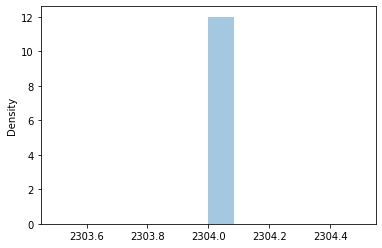

In [27]:
counts = joined_df.index.value_counts()
sns.distplot(counts)

#### Manual train-test split across scenario boundaries

In [28]:
import random
unique_scenarios = list(joined_df.index.unique())
unique_scenarios = sorted(unique_scenarios)
random.shuffle(unique_scenarios, random=lambda: 0.43)
train_scenarios = unique_scenarios[len(unique_scenarios)//3:]
test_scenarios = unique_scenarios[:len(unique_scenarios)//3]

train, train_labels = joined_df[joined_df.index.isin(train_scenarios)], labels[joined_df.index.isin(train_scenarios)]
test, test_labels = joined_df[joined_df.index.isin(test_scenarios)], labels[joined_df.index.isin(test_scenarios)]

In [29]:
train_scenarios

['training_0004-S3',
 'training_0000-S7',
 'training_0004-S7',
 'training_0000-S8',
 'training_0005-S10',
 'training_0000-S9',
 'training_0005-S15',
 'training_0005-S17',
 'training_0001-S0',
 'training_0005-S21',
 'training_0001-S1',
 'training_0005-S3',
 'training_0001-S10',
 'training_0005-S8',
 'training_0002-S23',
 'training_0001-S11',
 'training_0002-S3',
 'training_0001-S12',
 'training_0002-S5',
 'training_0001-S13',
 'training_0002-S7',
 'training_0002-S8',
 'training_0001-S14',
 'training_0003-S0',
 'training_0001-S15',
 'training_0003-S10',
 'training_0001-S16',
 'training_0003-S12',
 'training_0003-S13',
 'training_0001-S17',
 'training_0003-S15',
 'training_0001-S18',
 'training_0003-S17',
 'training_0001-S19',
 'training_0003-S19',
 'training_0003-S2',
 'training_0001-S2',
 'training_0003-S21',
 'training_0001-S20',
 'training_0003-S23',
 'training_0001-S21',
 'training_0003-S3',
 'training_0003-S4',
 'training_0001-S22',
 'training_0003-S6',
 'training_0001-S23',
 'train

#### Automated cross-validation splitter across scenario boundaries

In [30]:
def split_equally(lst, num_pieces):
    """Splits a list into pieces as equal a size as possible.
    Essentially takes any % leftovers from the last piece and distributes as equally as possible among the other pieces"""
    assert len(lst) > 0 and num_pieces > 0, (len(lst), num_pieces)
    assert len(lst) >= num_pieces, (len(lst), num_pieces)
    base_piece_size = len(lst) // num_pieces
    leftover = len(lst) % num_pieces
    for i in range(0, leftover*(base_piece_size+1), base_piece_size+1):  # the first few pieces with the extra modulo piece
        yield list(lst[i:i+(base_piece_size+1)])
    for i in range(leftover*(base_piece_size+1), len(lst), base_piece_size):  # the rest of the pieces
        yield list(lst[i:i+base_piece_size])

In [31]:
class ScenarioAwareCVSplitter:
    def __init__(self, n_splits=5, shuffle=False, random_state=None):
        self.n_splits = n_splits
        self.shuffle = shuffle
        self.random_state = random_state
    
    def get_n_splits(self, X=None, y=None, groups=None):
        return self.n_splits
    
    def split(self, X, y=None, groups=None):
        print(type(X))
        unique_scenarios = list(X.index.unique())
        if self.shuffle:
            random.shuffle(unique_scenarios, random=None)
        for scenario_list in split_equally(unique_scenarios, self.n_splits):
            all_indices = np.arange(len(X))
            test_mask = X.index.isin(scenario_list)
            yield (all_indices[~test_mask], all_indices[test_mask])


In [32]:
# Features for feature importances
features = list(train.columns)
features, len(features)

(['D-conf',
  'T-min-iou',
  'T-max-age',
  'T-every-nth-det',
  'avg_bbox_longevity',
  '90p_bbox_longevity',
  '90p_num_bboxes',
  '90p_bbox_speed',
  '90p_bbox_size',
  'avg_num_bboxes',
  'avg_bbox_speed',
  'avg_bbox_size',
  'avg_ego_speed',
  'D-model__efficientdet-d1',
  'D-model__efficientdet-d2',
  'D-model__efficientdet-d3',
  'D-model__efficientdet-d4',
  'D-model__efficientdet-d5',
  'D-model__efficientdet-d6',
  'D-model__efficientdet-d7',
  'D-model__efficientdet-d7x',
  'D-seq-pol__eager',
  'D-seq-pol__infinite',
  'D-seq-pol__tail-aware',
  'D-seq-pol__wait',
  'T-model__sort',
  'time_of_day__Dawn/Dusk',
  'time_of_day__Day',
  'time_of_day__Night',
  'location__location_other',
  'location__location_phx',
  'location__location_sf'],
 32)

### Do a bit of a cross-val hyperparameter search. This is very rudimentary.

In [37]:
from scipy.stats import loguniform, randint, uniform

In [41]:
model = RandomForestRegressor(random_state=RSEED, 
                              n_jobs=-1, verbose = 1)

In [34]:
[0.00005,0.0001,0.0002,0.0005,0.001,0.0015,0.002,0.005,0.01]

[5e-05, 0.0001, 0.0002, 0.0005, 0.001, 0.0015, 0.002, 0.005, 0.01]

In [35]:
x = loguniform(0.00005, 0.05, scale=2).rvs(size=10000)

(array([6724.,  992.,  553.,  394.,  290.,  284.,  224.,  200.,  194.,
         145.]),
 array([0.00010005, 0.01008217, 0.02006429, 0.0300464 , 0.04002852,
        0.05001064, 0.05999276, 0.06997488, 0.079957  , 0.08993912,
        0.09992124]),
 <BarContainer object of 10 artists>)

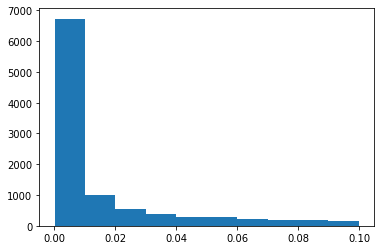

In [36]:
import matplotlib.pyplot as plt
plt.hist(x)

In [19]:
# 2:57pm start

In [43]:
clf = RandomizedSearchCV(model, {
    "max_depth": randint(1, 25),
    "max_features": randint(1, 24),
    "n_estimators": [200, 400, 800, 1600, 2400],
    "min_impurity_decrease": loguniform(0.00005, 0.05, scale=2),
    "max_samples": uniform(0.1, 0.9)
}, cv=ScenarioAwareCVSplitter(n_splits=5, shuffle=True, random_state=RSEED), n_iter=100)
clf.fit(train, train_labels)

<class 'pandas.core.frame.DataFrame'>


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 144 concurrent workers.
[Parallel(n_jobs=-1)]: Done 162 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done 512 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done 800 out of 800 | elapsed:    6.2s finished
[Parallel(n_jobs=144)]: Using backend ThreadingBackend with 144 concurrent workers.
[Parallel(n_jobs=144)]: Done 162 tasks      | elapsed:    0.2s
[Parallel(n_jobs=144)]: Done 512 tasks      | elapsed:    0.5s
[Parallel(n_jobs=144)]: Done 800 out of 800 | elapsed:    0.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 144 concurrent workers.
[Parallel(n_jobs=-1)]: Done 162 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 800 out of 800 | elapsed:    2.3s finished
[Parallel(n_jobs=144)]: Using backend ThreadingBackend with 144 concurrent workers.
[Parallel(n_jobs=144)]: Done 167 tasks      | elapsed:    0.5s
[Parallel(n_jobs=144)]: Done 517 tasks      | elapsed:    0.8s
[Parallel(n_jobs=144)]: 

RandomizedSearchCV(cv=<__main__.ScenarioAwareCVSplitter object at 0x7f493aad0a90>,
                   estimator=RandomForestRegressor(n_jobs=-1, random_state=50,
                                                   verbose=1),
                   n_iter=100,
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f493c6455c0>,
                                        'max_features': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f493aad0160>,
                                        'max_samples': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f493aad0550>,
                                        'min_impurity_decrease': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f493aad02b0>,
                                        'n_estimators': [200, 400, 800, 1600,
                                                         2400]})

In [44]:
clf.cv_results_

{'mean_fit_time': array([ 3.76119328,  2.38420501,  5.34827785,  6.12687254,  1.18373351,
        10.65819225,  1.12073884,  9.89693999,  1.02312827,  1.93792267,
         3.2922843 ,  2.13710155,  1.90877514,  3.38127766,  7.13590684,
         2.54338822,  9.04572468,  3.28123641,  7.2413929 ,  3.25925903,
         2.38257413,  1.11432743,  1.8162086 ,  8.71053395,  1.10079236,
         2.02836742,  1.46646171,  1.56254754,  6.54709725,  6.0416791 ,
         1.0351778 ,  5.29394102,  1.32970061,  5.16132321,  5.64113908,
         5.26225276,  3.20531664,  5.05182204,  1.21843963,  3.17294254,
         1.92867708,  2.73152695,  1.01664844,  6.33200231,  8.41143765,
         4.83791051,  2.72507606,  1.2094492 ,  1.02088795,  6.05942287,
         2.27330909,  1.00459533,  9.93137774,  7.61696692,  1.2213573 ,
         7.09733891,  9.66771379,  6.16696901,  1.05190921,  1.09220428,
         1.59650755,  1.34280605,  1.08068318, 16.83862257,  0.95372329,
         7.85804191,  2.06423397, 

In [46]:
clf.best_estimator_

RandomForestRegressor(max_depth=22, max_features=4,
                      max_samples=0.36548537006687265,
                      min_impurity_decrease=0.0009809206342033794,
                      n_estimators=1600, n_jobs=-1, random_state=50, verbose=1)

## Training

In [47]:
# Create the model with 100 trees
model = RandomForestRegressor(max_depth=22, max_features=4,
                      max_samples=0.36548537006687265,
                      min_impurity_decrease=0.0009809206342033794,
                      n_estimators=1600,
                              random_state=RSEED, 
#                               max_features = 'sqrt',
                              n_jobs=-1, verbose = 1)
# Fit on training data
model.fit(train, train_labels)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 144 concurrent workers.
[Parallel(n_jobs=-1)]: Done 162 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 512 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done 962 tasks      | elapsed:    7.1s
[Parallel(n_jobs=-1)]: Done 1600 out of 1600 | elapsed:   10.9s finished


RandomForestRegressor(max_depth=22, max_features=4,
                      max_samples=0.36548537006687265,
                      min_impurity_decrease=0.0009809206342033794,
                      n_estimators=1600, n_jobs=-1, random_state=50, verbose=1)

In [48]:
sorted(zip(features, model.feature_importances_), key=(lambda f: f[1]), reverse=True)

[('T-min-iou', 0.12798145196465335),
 ('90p_bbox_size', 0.09327452516987246),
 ('avg_num_bboxes', 0.09154157841885807),
 ('avg_bbox_size', 0.08736527054119303),
 ('avg_bbox_longevity', 0.08384168812299483),
 ('avg_ego_speed', 0.07932378227179068),
 ('90p_bbox_longevity', 0.07820098809610833),
 ('90p_num_bboxes', 0.07041791236462354),
 ('90p_bbox_speed', 0.046951683145889746),
 ('T-every-nth-det', 0.044990428693372955),
 ('avg_bbox_speed', 0.0432371776067397),
 ('T-max-age', 0.02106698576679439),
 ('D-model__efficientdet-d7x', 0.020358691359912345),
 ('D-model__efficientdet-d1', 0.01955634232259489),
 ('D-model__efficientdet-d7', 0.017917451591026406),
 ('location__location_sf', 0.012718108629793367),
 ('D-model__efficientdet-d2', 0.01263553149119505),
 ('location__location_phx', 0.009770102506162259),
 ('D-model__efficientdet-d4', 0.007086781105472229),
 ('location__location_other', 0.004777866467484511),
 ('D-model__efficientdet-d3', 0.004729014967509657),
 ('time_of_day__Day', 0.0040

In [49]:
n_nodes = []
max_depths = []

# Stats about the trees in random forest
for ind_tree in model.estimators_:
    n_nodes.append(ind_tree.tree_.node_count)
    max_depths.append(ind_tree.tree_.max_depth)
    
print(f'Average number of nodes {int(np.mean(n_nodes))}')
print(f'Average maximum depth {int(np.mean(max_depths))}')

Average number of nodes 5377
Average maximum depth 22


In [50]:
# Training predictions (to demonstrate overfitting)
train_rf_predictions = model.predict(train)
print("train score", model.score(train, train_labels))

# Testing predictions (to determine performance)
rf_predictions = model.predict(test)
print("test score", model.score(test, test_labels))

[Parallel(n_jobs=144)]: Using backend ThreadingBackend with 144 concurrent workers.
[Parallel(n_jobs=144)]: Done 162 tasks      | elapsed:    0.4s
[Parallel(n_jobs=144)]: Done 512 tasks      | elapsed:    0.7s
[Parallel(n_jobs=144)]: Done 962 tasks      | elapsed:    1.0s
[Parallel(n_jobs=144)]: Done 1600 out of 1600 | elapsed:    1.5s finished
[Parallel(n_jobs=144)]: Using backend ThreadingBackend with 144 concurrent workers.
[Parallel(n_jobs=144)]: Done 162 tasks      | elapsed:    0.2s
[Parallel(n_jobs=144)]: Done 512 tasks      | elapsed:    0.5s
[Parallel(n_jobs=144)]: Done 962 tasks      | elapsed:    0.9s
[Parallel(n_jobs=144)]: Done 1600 out of 1600 | elapsed:    1.4s finished
[Parallel(n_jobs=144)]: Using backend ThreadingBackend with 144 concurrent workers.


train score 0.9364238753359184


[Parallel(n_jobs=144)]: Done 169 tasks      | elapsed:    0.2s
[Parallel(n_jobs=144)]: Done 519 tasks      | elapsed:    0.4s
[Parallel(n_jobs=144)]: Done 969 tasks      | elapsed:    0.7s
[Parallel(n_jobs=144)]: Done 1600 out of 1600 | elapsed:    1.0s finished
[Parallel(n_jobs=144)]: Using backend ThreadingBackend with 144 concurrent workers.
[Parallel(n_jobs=144)]: Done 165 tasks      | elapsed:    0.2s
[Parallel(n_jobs=144)]: Done 515 tasks      | elapsed:    0.4s
[Parallel(n_jobs=144)]: Done 965 tasks      | elapsed:    0.7s


test score 0.42249483325401693


[Parallel(n_jobs=144)]: Done 1600 out of 1600 | elapsed:    1.0s finished


### Visualize confidence

In [288]:
def get_prediction_dist(model, data):
    return np.array([ind_tree.predict(data) for ind_tree in tqdm(model.estimators_)])

In [305]:
test_predictions = get_prediction_dist(model, test).T




  0%|          | 0/200 [00:00<?, ?it/s]


  2%|▏         | 4/200 [00:00<00:05, 33.43it/s]


  4%|▍         | 8/200 [00:00<00:05, 32.78it/s]


  6%|▌         | 12/200 [00:00<00:05, 33.00it/s]


  8%|▊         | 15/200 [00:00<00:05, 31.46it/s]


 10%|▉         | 19/200 [00:00<00:05, 32.12it/s]


 12%|█▏        | 23/200 [00:00<00:05, 32.57it/s]


 14%|█▎        | 27/200 [00:00<00:05, 33.11it/s]


 16%|█▌        | 31/200 [00:00<00:04, 33.97it/s]


 18%|█▊        | 35/200 [00:01<00:04, 34.18it/s]


 20%|█▉        | 39/200 [00:01<00:04, 34.78it/s]


 22%|██▏       | 43/200 [00:01<00:04, 34.71it/s]


 24%|██▎       | 47/200 [00:01<00:04, 35.11it/s]


 26%|██▌       | 51/200 [00:01<00:04, 34.83it/s]


 28%|██▊       | 55/200 [00:01<00:04, 35.13it/s]


 30%|██▉       | 59/200 [00:01<00:04, 34.88it/s]


 32%|███▏      | 63/200 [00:01<00:03, 35.40it/s]


 34%|███▎      | 67/200 [00:01<00:03, 35.06it/s]


 36%|███▌      | 71/200 [00:02<00:03, 35.55it/s]


 38%|███▊      | 75/200 [00:02<00:03, 3

In [308]:
test_preds = {scenario: test_predictions[test.index == scenario] for scenario in test.index.unique()}

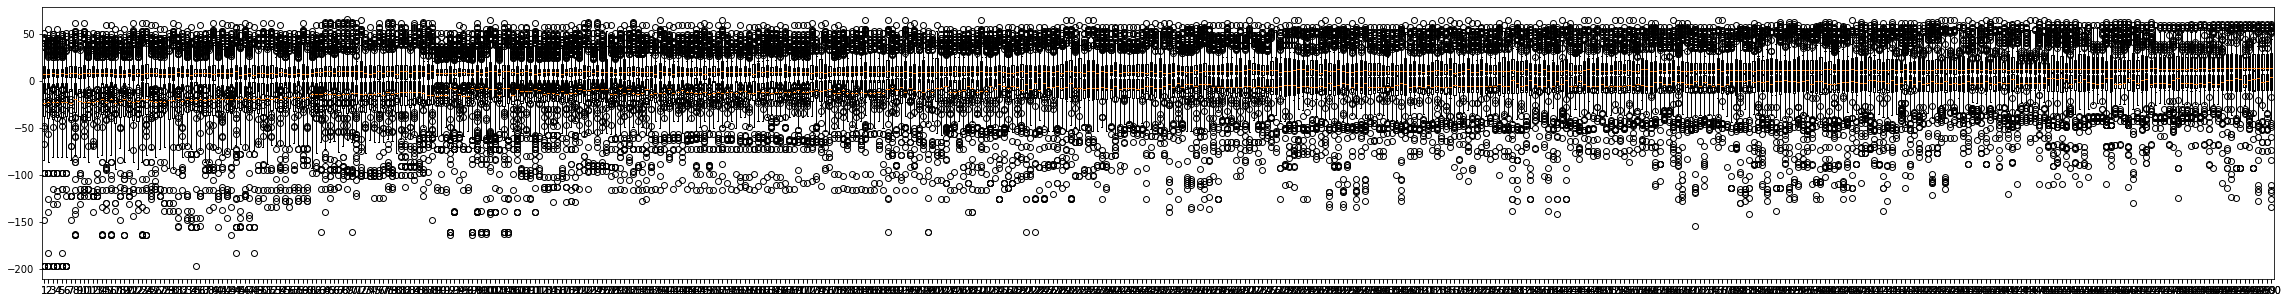

In [355]:
plt.figure(figsize=(40, 5))
scenario = "training_0002-S8"
sorted_by_mean = test_preds[scenario][np.argsort(np.mean(test_preds[scenario], axis=1))]
bottom_half = sorted_by_mean[:500].T
top_half = sorted_by_mean[-500:].T
plt.boxplot(bottom_half)
plt.boxplot(top_half)
plt.show()

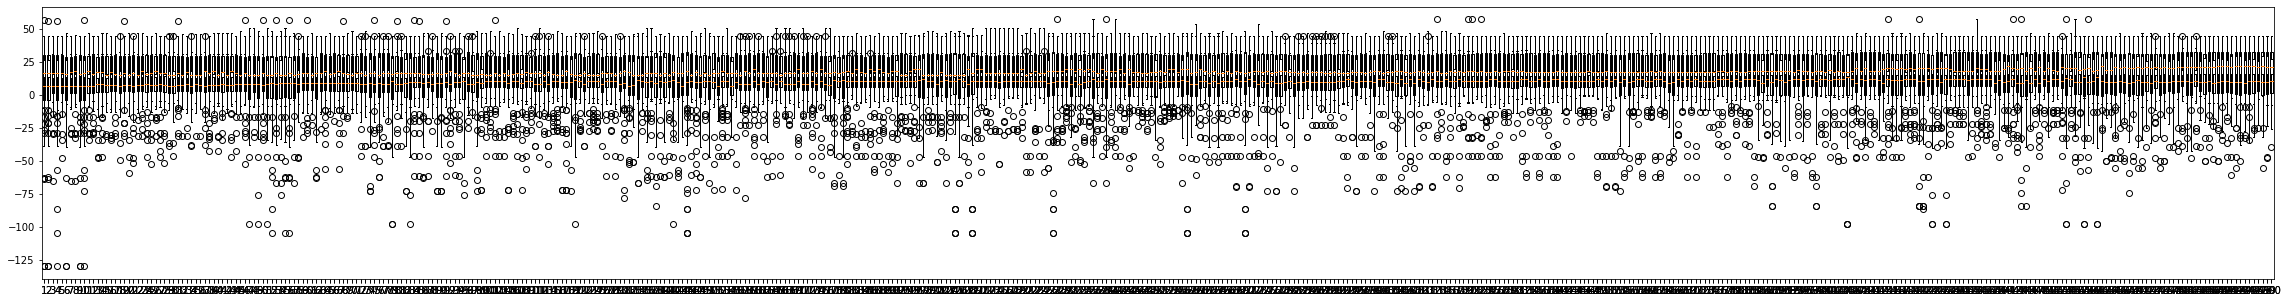

In [356]:
plt.figure(figsize=(40, 5))
scenario = "training_0004-S20"
sorted_by_mean = test_preds[scenario][np.argsort(np.mean(test_preds[scenario], axis=1))]
bottom_half = sorted_by_mean[:500].T
top_half = sorted_by_mean[-500:].T
plt.boxplot(bottom_half)
plt.boxplot(top_half)
# plt.boxplot(np.concatenate([bottom_half, top_half], axis=0))
plt.show()
# plt.boxplot(test_preds["training_0000-S0"][:1000].T)
# sns.ecdfplot(test_preds["training_0000-S0"])

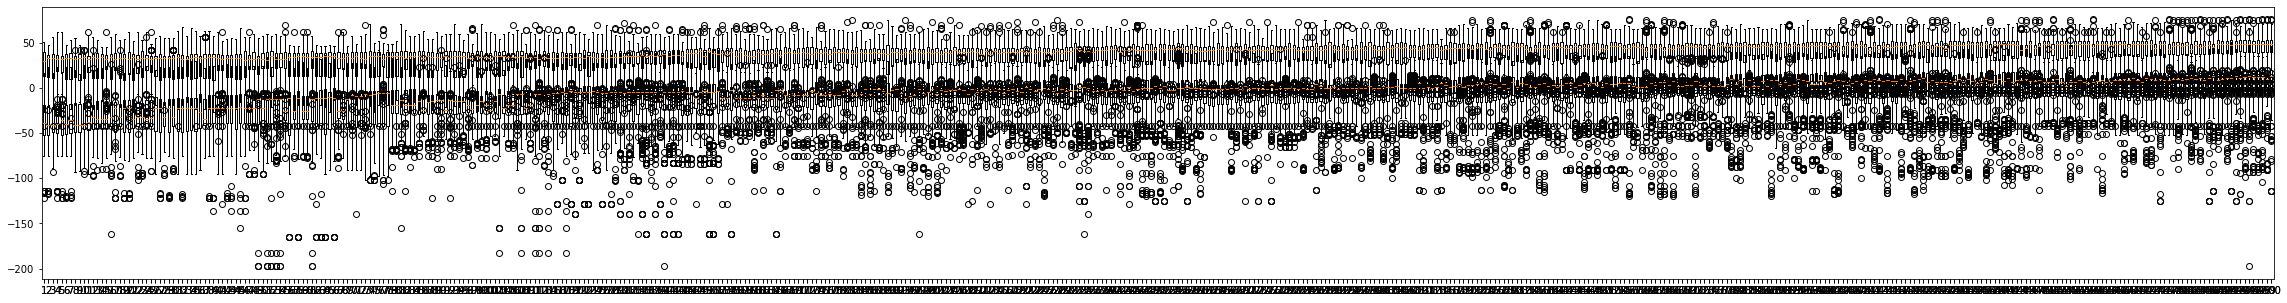

In [357]:
plt.figure(figsize=(40, 5))
scenario = "training_0001-S15"
sorted_by_mean = test_preds[scenario][np.argsort(np.mean(test_preds[scenario], axis=1))]
bottom_half = sorted_by_mean[:500].T
top_half = sorted_by_mean[-500:].T
plt.boxplot(bottom_half)
plt.boxplot(top_half)
# plt.boxplot(np.concatenate([bottom_half, top_half], axis=0))
plt.show()
# plt.boxplot(test_preds["training_0000-S0"][:1000].T)
# sns.ecdfplot(test_preds["training_0000-S0"])

## Using trained model to get best config and saving

In [51]:
train_copy = train.copy()
test_copy = test.copy()

In [52]:
train_copy["prediction"] = model.predict(train)
test_copy["prediction"] = model.predict(test)

[Parallel(n_jobs=144)]: Using backend ThreadingBackend with 144 concurrent workers.
[Parallel(n_jobs=144)]: Done 162 tasks      | elapsed:    0.2s
[Parallel(n_jobs=144)]: Done 512 tasks      | elapsed:    0.5s
[Parallel(n_jobs=144)]: Done 962 tasks      | elapsed:    1.0s
[Parallel(n_jobs=144)]: Done 1600 out of 1600 | elapsed:    1.5s finished
[Parallel(n_jobs=144)]: Using backend ThreadingBackend with 144 concurrent workers.
[Parallel(n_jobs=144)]: Done 163 tasks      | elapsed:    0.4s
[Parallel(n_jobs=144)]: Done 513 tasks      | elapsed:    0.6s
[Parallel(n_jobs=144)]: Done 963 tasks      | elapsed:    0.8s
[Parallel(n_jobs=144)]: Done 1600 out of 1600 | elapsed:    1.2s finished


In [53]:
train.index.unique()

Index(['training_0000-S7', 'training_0000-S8', 'training_0000-S9',
       'training_0001-S0', 'training_0001-S1', 'training_0001-S10',
       'training_0001-S11', 'training_0001-S12', 'training_0001-S13',
       'training_0001-S14', 'training_0001-S15', 'training_0001-S16',
       'training_0001-S17', 'training_0001-S18', 'training_0001-S19',
       'training_0001-S2', 'training_0001-S20', 'training_0001-S21',
       'training_0001-S22', 'training_0001-S23', 'training_0001-S3',
       'training_0001-S4', 'training_0001-S5', 'training_0001-S6',
       'training_0001-S7', 'training_0001-S8', 'training_0001-S9',
       'training_0002-S0', 'training_0002-S1', 'training_0002-S10',
       'training_0002-S11', 'training_0002-S12', 'training_0002-S13',
       'training_0002-S14', 'training_0002-S15', 'training_0002-S16',
       'training_0002-S17', 'training_0002-S18', 'training_0002-S19',
       'training_0002-S2', 'training_0002-S20', 'training_0002-S21',
       'training_0002-S22', 'trainin

In [54]:
test.index.unique()

Index(['training_0000-S0', 'training_0000-S1', 'training_0000-S10',
       'training_0000-S11', 'training_0000-S12', 'training_0000-S13',
       'training_0000-S14', 'training_0000-S15', 'training_0000-S16',
       'training_0000-S17', 'training_0000-S18', 'training_0000-S19',
       'training_0000-S2', 'training_0000-S20', 'training_0000-S21',
       'training_0000-S22', 'training_0000-S23', 'training_0000-S3',
       'training_0000-S4', 'training_0000-S5', 'training_0000-S6',
       'training_0002-S24', 'training_0002-S4', 'training_0002-S6',
       'training_0002-S9', 'training_0003-S1', 'training_0003-S11',
       'training_0003-S14', 'training_0003-S16', 'training_0003-S18',
       'training_0003-S20', 'training_0003-S22', 'training_0003-S24',
       'training_0003-S5', 'training_0003-S7', 'training_0003-S9',
       'training_0004-S1', 'training_0004-S12', 'training_0004-S14',
       'training_0004-S16', 'training_0004-S19', 'training_0004-S20',
       'training_0004-S22', 'traini

In [55]:
train_copy["run_name"] = train_copy.index
test_copy["run_name"] = test_copy.index

In [56]:
to_predict = test_copy

In [57]:
best_predicted_configs = pd.DataFrame([rows.iloc[rows["prediction"].argmax()] for run_name, rows in to_predict.groupby(["run_name"])])

In [58]:
parent_columns = set([c.split("__")[0] for c in best_predicted_configs.columns if "__" in c])
for pc in parent_columns:
    ccs = list(filter(lambda cc: cc.startswith(pc), best_predicted_configs.columns))
    rows = best_predicted_configs[ccs]
    rows.columns = [cc.split("__")[1] for cc in ccs]
    best_predicted_configs[pc] = rows.idxmax(axis=1)
    best_predicted_configs = best_predicted_configs.drop(columns=ccs)

In [59]:
best_predicted_configs

,D-conf,T-min-iou,T-max-age,T-every-nth-det,avg_bbox_longevity,90p_bbox_longevity,90p_num_bboxes,90p_bbox_speed,90p_bbox_size,avg_num_bboxes,avg_bbox_speed,avg_bbox_size,avg_ego_speed,prediction,run_name,D-seq-pol,T-model,time_of_day,D-model,location
training_0000-S0,0.5,0.1,3,1,85.080000,169.8,14.0,95.804566,34172.474092,10.742424,56.625234,23269.829340,5.588190,39.865013,training_0000-S0,eager,sort,Day,efficientdet-d4,location_sf
training_0000-S1,0.5,0.1,5,1,103.259259,175.0,50.0,49.616457,46870.875085,42.030151,30.518480,52875.208306,0.383722,30.765153,training_0000-S1,eager,sort,Day,efficientdet-d4,location_sf
training_0000-S10,0.3,0.1,3,1,56.454545,105.0,4.0,76.439390,38357.517547,3.120603,41.192411,17850.350271,4.144654,35.420303,training_0000-S10,wait,sort,Dawn/Dusk,efficientdet-d4,location_sf
training_0000-S11,0.5,0.1,1,1,53.425000,99.6,38.0,41.488826,2842.560143,32.378788,33.613229,2000.154715,19.094199,12.083621,training_0000-S11,wait,sort,Day,efficientdet-d4,location_phx
training_0000-S12,0.5,0.1,1,1,45.666667,126.0,8.0,185.012790,26528.361155,4.843434,69.958587,8737.199796,8.112840,30.402031,training_0000-S12,eager,sort,Night,efficientdet-d4,location_phx
training_0000-S13,0.3,0.1,5,1,65.357143,192.6,43.3,25.798442,55747.348700,23.106061,17.399413,38025.392681,1.142726,27.775125,training_0000-S13,wait,sort,Dawn/Dusk,efficientdet-d4,location_sf
training_0000-S14,0.5,0.1,7,1,103.153846,198.0,46.0,26.803467,8849.946543,33.863636,16.176909,6910.080792,2.374864,23.646372,training_0000-S14,tail-aware,sort,Day,efficientdet-d7x,location_phx
training_0000-S15,0.5,0.1,3,1,76.118421,192.5,33.0,76.705012,18219.508422,29.217172,49.077779,12410.133293,4.609326,30.769023,training_0000-S15,eager,sort,Night,efficientdet-d4,location_sf
training_0000-S16,0.5,0.1,3,1,82.721649,194.4,52.2,44.823852,18010.665024,40.321608,26.818691,13557.233961,6.141586,24.966117,training_0000-S16,eager,sort,Day,efficientdet-d4,location_sf
training_0000-S17,0.3,0.1,1,1,42.065868,100.0,55.0,240.021246,10265.541383,35.301508,102.823789,7670.240834,6.222526,23.238868,training_0000-S17,eager,sort,Day,efficientdet-d4,location_sf


In [60]:
RF_policy_map = {}
for index, row in best_predicted_configs.iterrows():
    config_columns=["D-model", "D-conf", "D-seq-pol", "T-min-iou", "T-max-age", "T-every-nth-det"]
    RF_policy_map[index] = {c: row[c] for c in config_columns}

In [62]:
import pickle
with open("RF_test_policy_map_condensed_k_10.pl", 'wb') as f:
    pickle.dump(RF_policy_map, f)